<a href="https://colab.research.google.com/github/Vaycold/tensorflow_tutorial/blob/main/%238.%EC%9D%B4%EB%AF%B8%EC%A7%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import os
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [4]:
print(tf.__version__)

2.5.0


In [5]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin = dataset_url,
                                   fname = 'flower_photos',
                                   untar = True)
data_dir = pathlib.Path(data_dir)

228818944/228813984 [==============================] - 5s 0us/step


In [8]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


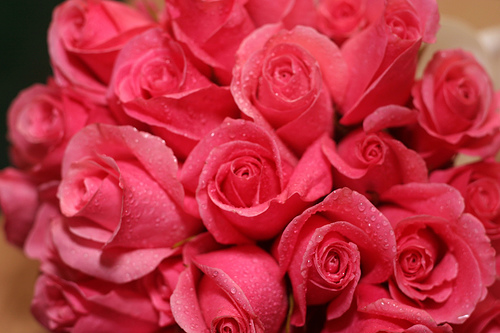

In [14]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

In [15]:
# keras.preprocessing 사용하여 로드

batch_size = 32
height = 180
width = 180

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = 'training',
    seed = 123,
    image_size = (height, width),
    batch_size = batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [16]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = 'validation',
    seed = 123,
    image_size = (height, width),
    batch_size = batch_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [17]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


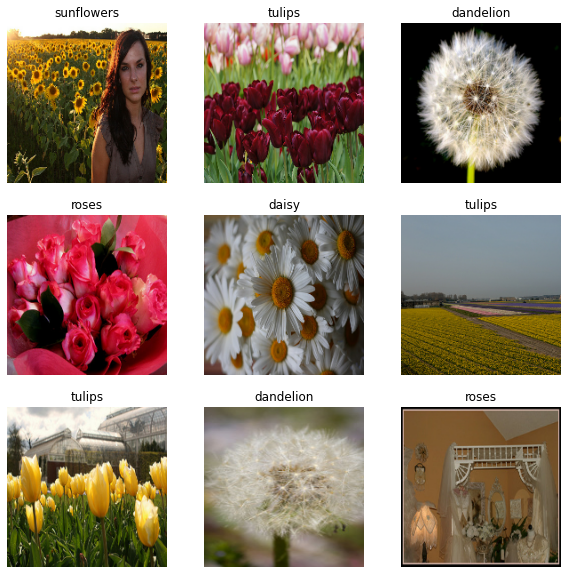

In [23]:
# 데이터 시각화
# 훈련 데이터 셋의 처음 9개

import matplotlib.pyplot as plt

plt.figure(figsize = (10,10))

for images, labels in train_ds.take(1) :
    for i in range(9) :
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [25]:
for image_batch, labels_batch in train_ds :
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [26]:
# RGB 채널값은 [0,255] 범위에 존재 
# - Rescailing layer 사용하여 값이 [0,1]에 있도록 변경

from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [28]:
# 위의 레이어를 사용하는 데에는 2가지 방법 존재
# 1. map을 호출하여 데이터 세트에 레이어 적용

normal_ds = train_ds.map(lambda x,y : (normalization_layer(x), y))
img_batch, lab_batch = next(iter(normal_ds))
first_img = img_batch[0]
print(first_img.numpy().min(), first_img.numpy().max())


# tf.keras.layers.experimental.preprocessing.Resizing 을 사용하여 이미지크기를 조절하는 레이어 생성 가능

0.0 1.0


In [30]:
# 또는 모델 정의 내에 레이어를 포함하여 배포를 단순화

# 성능을 위한 데이터셋 구성
# .cache() : 첫 번째 epoch 동안 디스크에서 이미지를 로드한 후 이미지를 메모리에 유지
#           - 모델 훈련 동안 데이터셋이 병목 상태가 되지 않음.
#           - 데이터셋이 너무 커서 메모리에 맞지 않는 경우, 성능이 높은 온디스크 캐시를 생성 가능

AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [33]:
num_classes = 5
tf.keras.layers.MaxPooling2D
model = tf.keras.Sequential([
            tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
            tf.keras.layers.Conv2D(32, 3, activation = 'relu'),
            tf.keras.layers.MaxPooling2D(),
            tf.keras.layers.Conv2D(32, 3, activation = 'relu'),
            tf.keras.layers.MaxPooling2D(),
            tf.keras.layers.Conv2D(32, 3, activation = 'relu'),
            tf.keras.layers.MaxPooling2D(),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation = 'relu'),
            tf.keras.layers.Dense(num_classes)
            ])

In [34]:
model.compile(optimizer = 'adam',
              loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])

In [35]:
model.fit(train_ds, 
          batch_size = batch_size,
          validation_data = val_ds,
          epochs = 3)

Epoch 1/3
92/92 [==============================] - 126s 1s/step - loss: 1.2841 - accuracy: 0.4642 - val_loss: 1.0763 - val_accuracy: 0.5763
Epoch 2/3
92/92 [==============================] - 113s 1s/step - loss: 0.9790 - accuracy: 0.6270 - val_loss: 0.9423 - val_accuracy: 0.6131
Epoch 3/3
92/92 [==============================] - 115s 1s/step - loss: 0.8182 - accuracy: 0.6962 - val_loss: 0.8670 - val_accuracy: 0.6594


In [36]:
# Tensorflow dataset 사용
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split = ['train[:80%]', 'train[80%:90%]','train[90%:]'],
    with_info = True,
    as_supervised =True,
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [38]:
num_classes = metadata.features['label'].num_classes;print(num_classes)

5


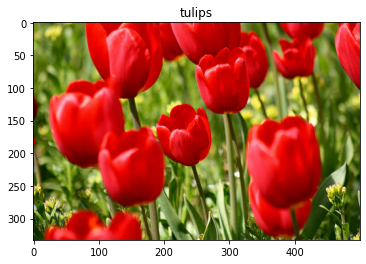

In [39]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))